# Testing the environment
---
## Setup

In [117]:
from rl4caribou import CaribouScipy
import numpy as np

In [118]:
env = CaribouScipy()

## Testing Wolf-Moose equilibrium

In [119]:
# set environment randomness to zero
env.parameters['sigma_M'], env.parameters['sigma_B'], env.parameters['sigma_W'] = 0, 0, 0 

In [38]:
T = 800
obs, info = env.reset()
M, B, W = env.bound * (obs + 1) /2 
Ms, Bs, Ws = [M], [B], [W]
for t in range(T):
    obs, reward, terminated, truncated, info = env.step(np.array([-1, -1, -1]))
    M, B, W = env.bound * (obs + 1) /2 
    Ms.append(M)
    Bs.append(B)
    Ws.append(W)
    


In [120]:
import pandas as pd

simulation = pd.DataFrame(
    {
        't': [t for t in range(T+1)],
        'M': Ms,
        'B': Bs,
        'W': Ws,
    }
)

<Axes: xlabel='t'>

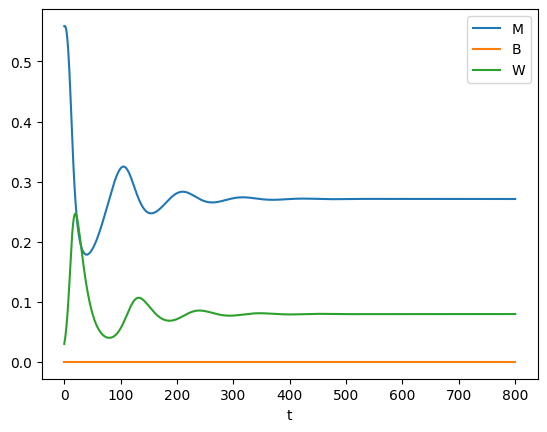

In [40]:
simulation.plot(x='t')

In [41]:
Ms[-1], Bs[-1], Ws[-1] # the -1 in this space is the last one (like the tail function in R)

(0.2711187, 0.0, 0.07967687)

## Ok we start from Moose-Wolf fixed point now

In [114]:
env.initial_pop = np.array([0.2711187, 0.0001, 0.07967687])

## We start managing

In [43]:
from rl4caribou.agents import constAction

In [66]:
pacifist = constAction(mortality_vec=np.array([0,0,0]))

In [67]:
def simulate(env, agent):
    T = 800
    obs, info = env.reset()
    M, B, W = env.bound * (obs + 1) /2 
    Ms, Bs, Ws = [M], [B], [W]
    for t in range(T):
        action, info = agent.predict(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        M, B, W = env.bound * (obs + 1) /2 
        Ms.append(M)
        Bs.append(B)
        Ws.append(W)
    return pd.DataFrame(
        {
            't': [t for t in range(T+1)],
            'M': Ms,
            'B': Bs,
            'W': Ws,
        }
    )

In [68]:
df = simulate(
    CaribouScipy(
        config={'initial_pop': np.array([0.2711187, 0.00001, 0.07967687])}
    ), 
    pacifist
)

<Axes: xlabel='t'>

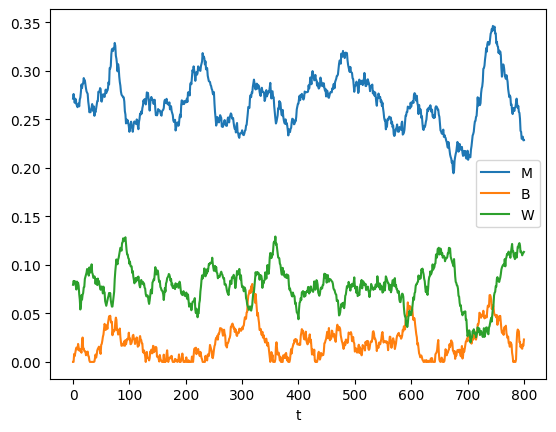

In [69]:
df.plot(x='t')

In [115]:
from stable_baselines3 import PPO # stable_baselines3 is the package with the algorithms

ppoAgent = PPO.load("../saved_agents/PPO-CaribouScipy-LFupdate.zip") 


In [121]:
simulate(env, ppoAgent)

ValueError: Error: Unexpected observation shape (3,) for Box environment, please use (4,) or (n_env, 4) for the observation shape.

In [98]:
df = simulate(
    CaribouScipy(
        config={'initial_pop': np.array([0.2711187, 0.0001, 0.07967687])}
    ), 
    ppoAgent
)

<Axes: xlabel='t'>

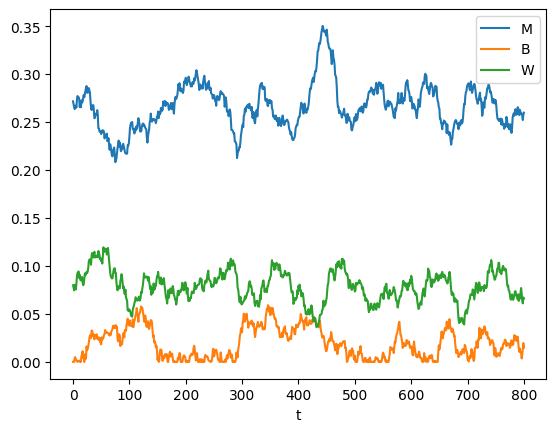

In [99]:
df.plot(x='t')

In [100]:
def simulate2(env, agent):
    T = 10000
    obs, info = env.reset()
    M, B, W = env.bound * (obs + 1) /2 
    Ms, Bs, Ws, moosecull, wolfcull, LFrest  = [M], [B], [W], [0], [0], [0] # the initial state there is no action yet
    for t in range(T):
        action, info = agent.predict(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        M, B, W = env.bound * (obs + 1) /2 
        Ms.append(M)
        Bs.append(B)
        Ws.append(W)
        moosecull.append((action[0]+1)/2)
        wolfcull.append((action[1]+1)/2)
        LFrest.append((action[2]+1)/2)
        
    return pd.DataFrame(
        {
            't': [t for t in range(T+1)],
            'M': Ms,
            'B': Bs,
            'W': Ws,
            'moosecull': moosecull,
            'wolfcull': wolfcull,
            'LFrest': LFrest
        }
    )

In [101]:
df2 = simulate2(
    CaribouScipy(
        config={'initial_pop': np.array([0.2711187, 0.0001, 0.07967687])}
    ), 
    ppoAgent
)

<Axes: xlabel='t'>

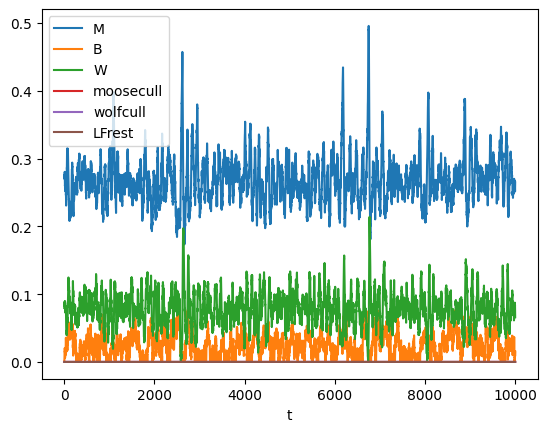

In [102]:
df2.plot(x='t')

In [65]:
df2 #moose = 0.125875, caribou = 0.200913, wolves = 0.011156, moosecull = 0.221668

,t,M,B,W,moosecull,wolfcull,LFrest
0,0,0.271592,0.000100,0.079572,0.000000,0.0,0.0
1,1,0.265559,0.000000,0.076070,0.697784,0.0,0.0
2,2,0.245124,0.005083,0.068542,0.677970,0.0,0.0
3,3,0.237694,0.008161,0.066559,0.600875,0.0,0.0
4,4,0.226830,0.015626,0.060497,0.570898,0.0,0.0
...,...,...,...,...,...,...,...
9996,9996,0.127768,0.193602,0.011291,0.185205,0.0,0.0
9997,9997,0.125947,0.194216,0.010702,0.221801,0.0,0.0
9998,9998,0.126776,0.197395,0.009379,0.214861,0.0,0.0
9999,9999,0.124897,0.204178,0.007722,0.223531,0.0,0.0


In [103]:
df2['moosecull'].mean()

0.0

What's interesting is that no wolf culls are enacted, but the wolf populations are kept tamped down purely by lack of prey. this suggests in a limited trophic system (only prey for wolves are modeled), mooseculls would be enough to actually dampen wolf populations 

Now let's try a constant action instead of learning, and see how they compare 

In [104]:
constantmoosecull = constAction(mortality_vec=np.array([0.25019748630884014,0,0]))

In [105]:
df3 = simulate2(
    CaribouScipy(
        config={'initial_pop': np.array([0.2711187, 0.00001, 0.07967687])}
    ), 
    constantmoosecull
)

<Axes: xlabel='t'>

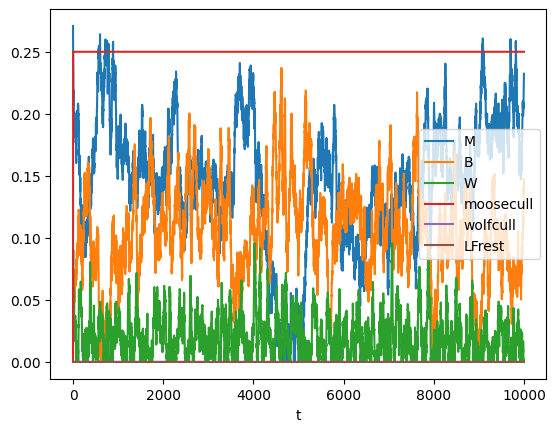

In [106]:
df3.plot(x='t')

In [76]:
df3

,t,M,B,W,moosecull,wolfcull,LFrest
0,0,0.271189,0.000010,0.079750,0.000000,0.0,0.0
1,1,0.270140,0.003327,0.076394,0.250197,0.0,0.0
2,2,0.263498,0.000000,0.080482,0.250197,0.0,0.0
3,3,0.262655,0.002641,0.081421,0.250197,0.0,0.0
4,4,0.262952,0.002622,0.081798,0.250197,0.0,0.0
...,...,...,...,...,...,...,...
9996,9996,0.212014,0.103054,0.015200,0.250197,0.0,0.0
9997,9997,0.213589,0.095945,0.013633,0.250197,0.0,0.0
9998,9998,0.214614,0.088864,0.017539,0.250197,0.0,0.0
9999,9999,0.214608,0.089382,0.020956,0.250197,0.0,0.0


In [ ]:
#moose =0.208092, caribou = 0.086198, wolves = 0.020009

everything is a lower equilibrium value that with the dynamic learning algorithm, especially caribou

In [107]:
constantwolf = constAction(mortality_vec=np.array([0,0.25019748630884014,0]))

In [108]:
df4 = simulate2(
    CaribouScipy(
        config={'initial_pop': np.array([0.2711187, 0.00001, 0.07967687])}
    ), 
    constantwolf
)

<Axes: xlabel='t'>

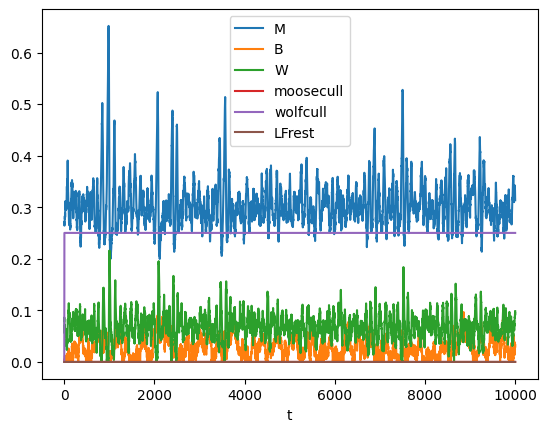

In [109]:
df4.plot(x='t')

In [85]:
df4

,t,M,B,W,moosecull,wolfcull,LFrest
0,0,0.271175,0.000010,0.079726,0.0,0.000000,0.0
1,1,0.273684,0.002226,0.074774,0.0,0.250197,0.0
2,2,0.264629,0.002657,0.078230,0.0,0.250197,0.0
3,3,0.263383,0.004321,0.073357,0.0,0.250197,0.0
4,4,0.263843,0.005527,0.069465,0.0,0.250197,0.0
...,...,...,...,...,...,...,...
9996,9996,0.260629,0.017928,0.070502,0.0,0.250197,0.0
9997,9997,0.268508,0.017746,0.059063,0.0,0.250197,0.0
9998,9998,0.265086,0.014298,0.060345,0.0,0.250197,0.0
9999,9999,0.269537,0.018293,0.064447,0.0,0.250197,0.0


In [110]:
merged = pd.DataFrame(
        {
            't': df2['t'],
            'dynammoose': df2['B'],
            'constmoose': df3['B'],
            'constwolf': df4['B']
        }
)

<Axes: xlabel='t'>

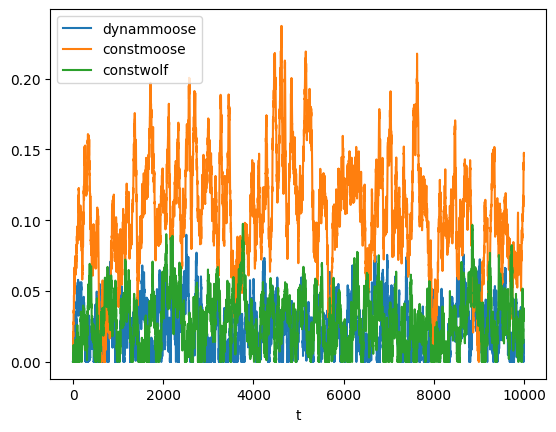

In [111]:
merged.plot(x='t')